In [1]:
import keras
keras.__version__

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [2]:
from keras.applications.resnet50 import ResNet50

conv_base = ResNet50(weights='imagenet',
                    include_top=False,
                    input_shape=(224, 224, 3))

In [3]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

datagen = ImageDataGenerator()
#datagen = ImageDataGenerator(rescale=1./255)
batch_size = 15

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

def extract_features_test(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 2048))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None)
    i = 0
    for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features

test_features = extract_features_test(test_dir, 12500)
train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)

Found 12500 images belonging to 1 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (20000, 1 * 1 * 2048))
validation_features = np.reshape(validation_features, (5000, 1 * 1 * 2048))
test_features = np.reshape(test_features, (12500, 1 * 1 * 2048))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_dim=1 * 1 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [7]:
history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=120,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 1s 38us/step - loss: 0.2011 - acc: 0.9192 - val_loss: 0.0778 - val_acc: 0.9750
Epoch 2/100
20000/20000 [==============================] - 1s 27us/step - loss: 0.0836 - acc: 0.9673 - val_loss: 0.0680 - val_acc: 0.9742
Epoch 3/100
20000/20000 [==============================] - 1s 29us/step - loss: 0.0712 - acc: 0.9713 - val_loss: 0.0647 - val_acc: 0.9752
Epoch 4/100
20000/20000 [==============================] - 1s 28us/step - loss: 0.0646 - acc: 0.9751 - val_loss: 0.0651 - val_acc: 0.9750
Epoch 5/100
20000/20000 [==============================] - 1s 28us/step - loss: 0.0598 - acc: 0.9764 - val_loss: 0.0634 - val_acc: 0.9760
Epoch 6/100
20000/20000 [==============================] - 1s 28us/step - loss: 0.0557 - acc: 0.9790 - val_loss: 0.0636 - val_acc: 0.9762
Epoch 7/100
20000/20000 [==============================] - 1s 30us/step - loss: 0.0543 - acc: 0.9785 - val_loss: 0.0624 - v

20000/20000 [==============================] - 1s 26us/step - loss: 0.0103 - acc: 0.9979 - val_loss: 0.0734 - val_acc: 0.9760
Epoch 60/100
20000/20000 [==============================] - 1s 27us/step - loss: 0.0098 - acc: 0.9980 - val_loss: 0.0739 - val_acc: 0.9764
Epoch 61/100
20000/20000 [==============================] - 1s 28us/step - loss: 0.0099 - acc: 0.9979 - val_loss: 0.0735 - val_acc: 0.9756
Epoch 62/100
20000/20000 [==============================] - 1s 32us/step - loss: 0.0095 - acc: 0.9983 - val_loss: 0.0740 - val_acc: 0.9752
Epoch 63/100
20000/20000 [==============================] - 1s 31us/step - loss: 0.0091 - acc: 0.9980 - val_loss: 0.0743 - val_acc: 0.9758
Epoch 64/100
20000/20000 [==============================] - 1s 31us/step - loss: 0.0090 - acc: 0.9981 - val_loss: 0.0750 - val_acc: 0.9760
Epoch 65/100
20000/20000 [==============================] - 1s 33us/step - loss: 0.0086 - acc: 0.9986 - val_loss: 0.0751 - val_acc: 0.9762
Epoch 66/100
20000/20000 [==============

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [9]:
from keras.preprocessing import image
from keras.models import Model 
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras import backend as K

x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=conv_base.input, outputs=predictions)

In [10]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 216


In [11]:
for layer in conv_base.layers:
    layer.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      #rescale=1./255
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
#test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=50,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [13]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=100,
      verbose=2)

Epoch 1/30
 - 197s - loss: 0.2479 - acc: 0.8985 - val_loss: 0.1042 - val_acc: 0.9600
Epoch 2/30
 - 191s - loss: 0.1549 - acc: 0.9382 - val_loss: 0.1172 - val_acc: 0.9568
Epoch 3/30
 - 191s - loss: 0.1412 - acc: 0.9443 - val_loss: 0.0973 - val_acc: 0.9660
Epoch 4/30
 - 192s - loss: 0.1303 - acc: 0.9481 - val_loss: 0.1380 - val_acc: 0.9534
Epoch 5/30
 - 191s - loss: 0.1368 - acc: 0.9432 - val_loss: 0.1058 - val_acc: 0.9646
Epoch 6/30
 - 191s - loss: 0.1311 - acc: 0.9459 - val_loss: 0.1020 - val_acc: 0.9664
Epoch 7/30
 - 191s - loss: 0.1247 - acc: 0.9491 - val_loss: 0.1119 - val_acc: 0.9636
Epoch 8/30
 - 191s - loss: 0.1240 - acc: 0.9508 - val_loss: 0.0977 - val_acc: 0.9688
Epoch 9/30
 - 192s - loss: 0.1306 - acc: 0.9456 - val_loss: 0.1185 - val_acc: 0.9624
Epoch 10/30
 - 191s - loss: 0.1203 - acc: 0.9534 - val_loss: 0.1092 - val_acc: 0.9652
Epoch 11/30
 - 191s - loss: 0.1230 - acc: 0.9496 - val_loss: 0.1225 - val_acc: 0.9602
Epoch 12/30
 - 192s - loss: 0.1299 - acc: 0.9484 - val_loss: 0.

In [14]:
model.save('ResNet50_feature_extraction.h5')

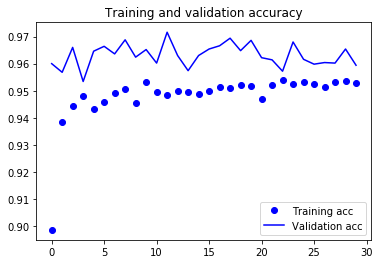

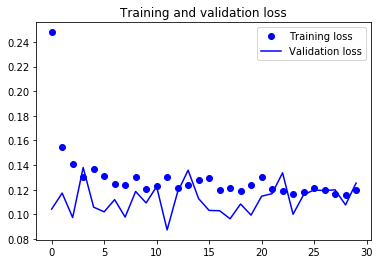

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
for layer in model.layers[:168]:
    layer.trainable = False
for layer in model.layers[168:]:
    layer.trainable = True

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100)

Epoch 1/100
400/400 [==============================] - 198s 494ms/step - loss: 0.1128 - acc: 0.9555 - val_loss: 0.1028 - val_acc: 0.9670
Epoch 2/100
400/400 [==============================] - 193s 483ms/step - loss: 0.1095 - acc: 0.9569 - val_loss: 0.1012 - val_acc: 0.9682
Epoch 3/100
400/400 [==============================] - 193s 482ms/step - loss: 0.1116 - acc: 0.9573 - val_loss: 0.0995 - val_acc: 0.9680
Epoch 4/100
400/400 [==============================] - 193s 482ms/step - loss: 0.1091 - acc: 0.9559 - val_loss: 0.1075 - val_acc: 0.9658
Epoch 5/100
400/400 [==============================] - 193s 483ms/step - loss: 0.1108 - acc: 0.9568 - val_loss: 0.0995 - val_acc: 0.9688
Epoch 6/100
400/400 [==============================] - 193s 482ms/step - loss: 0.1051 - acc: 0.9585 - val_loss: 0.1116 - val_acc: 0.9642
Epoch 7/100
400/400 [==============================] - 195s 487ms/step - loss: 0.1071 - acc: 0.9581 - val_loss: 0.1040 - val_acc: 0.9678
Epoch 8/100
400/400 [====================

400/400 [==============================] - 193s 482ms/step - loss: 0.0793 - acc: 0.9691 - val_loss: 0.0910 - val_acc: 0.9728
Epoch 61/100
400/400 [==============================] - 193s 481ms/step - loss: 0.0790 - acc: 0.9698 - val_loss: 0.0908 - val_acc: 0.9724
Epoch 62/100
400/400 [==============================] - 193s 482ms/step - loss: 0.0765 - acc: 0.9704 - val_loss: 0.0998 - val_acc: 0.9716
Epoch 63/100
400/400 [==============================] - 193s 482ms/step - loss: 0.0782 - acc: 0.9688 - val_loss: 0.0920 - val_acc: 0.9728
Epoch 64/100
400/400 [==============================] - 194s 484ms/step - loss: 0.0799 - acc: 0.9694 - val_loss: 0.1013 - val_acc: 0.9706
Epoch 65/100
400/400 [==============================] - 193s 483ms/step - loss: 0.0764 - acc: 0.9711 - val_loss: 0.0950 - val_acc: 0.9730
Epoch 66/100
400/400 [==============================] - 194s 485ms/step - loss: 0.0810 - acc: 0.9687 - val_loss: 0.0944 - val_acc: 0.9730
Epoch 67/100
400/400 [=========================

In [19]:
model.save('ResNet50_Finetuning.h5')

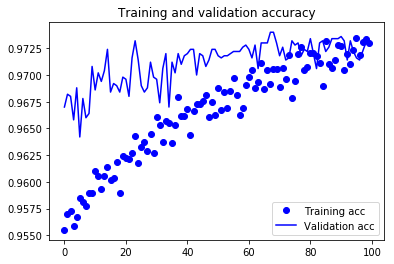

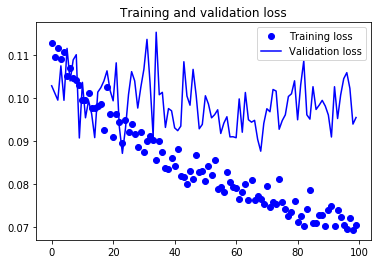

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

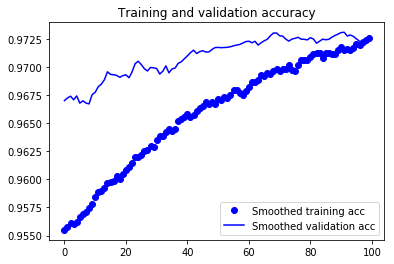

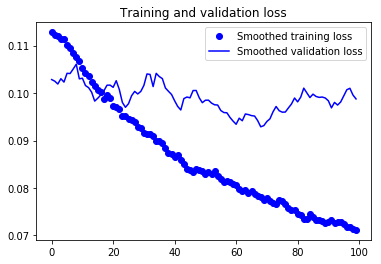

In [23]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_poin7171ts.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()